# Introduction to the Kalman filter

In [12]:
# imports

import pandas as pd
from matplotlib import pyplot as plt
import scipy.linalg as la
import numpy as np
import scipy.interpolate as interp
import scipy.stats as stats
from abc import ABC, abstractmethod
from copy import deepcopy
%matplotlib inline

## Dynamic systems

A dynamic system is, roughly speaking, any system that evolves in time. This evolution in time is based on its initial state, the system input, and some underlying equations. The classic example of a dynamic system is a cart on rails, whose initial state is known to be an $x$ position and $x$ velocity of zero, and that moves based on an applied force, which is the system input. Once a force is applied, the cart starts to move according to Newton's laws:

$\begin{eqnarray*}
x = x_0 + v_0 t + \frac{f}{2m} t^2\\
v = v_0 + \frac{f}{m}t \end{eqnarray*}$

These are the state-transition rules of the cart.

We can make predictions about the state of a dynamic system based on its state-transition rules and knowing some initial state. However, when these dynamic systems are implemented in practice, the state transitions do not perfectly match the predictions. The predictions do not account for environmental disturbances, which cannot be accurately estimated upfront. In the case of the cart, there may be a friction force preventing the cart from moving perfectly according to its state-transition rules. Therefore there is some uncertainty surrounding the prediction as to how close it is to the actual state.

The purpose of a Kalman filter is to combine the predicted system state (including uncertainty) with measurements of the system that are noisy and therefore have their own uncertainty, in order to get a better estimate of the system state over time. 

A succinct way to describe what a Kalman filter does is that it combines *physics* and *reality*: we build a physical model to obtain some expectation of what a system should do at any given time, and we combine that with what we know is really happening 

## State-space representation of dynamic systems

Dynamic systems can be represented in *state space* by defining a *state vector* of the form $\vec{x} = [\begin{matrix} x_1 & x_2 & \dots & x_n \end{matrix}]^T$ that contains variables describing the system.

A dynamic system can be described based on the time-evolution of the system state as well as how the system output $\vec{y}$ relates to the control input $\vec{u}$ and state. This is done in continuous time by specifying a set of first-order differential equations and combining them into one equation using matrices,

$\begin{eqnarray*}
    \vec{\dot{x}}(t) = A'\vec{x}(t) + B'\vec{u}(t)\\
    \vec{y}(t) = C'\vec{x}(t) + D'\vec{u}(t)
\end{eqnarray*}$

Typically, the matrix $A'$ is referred to as the *state-transition matrix* and the first equation is the *state-transition equation*. To verbally describe the other matrices, you could call $B'$ the *state-transition input gain*, $C'$ the *state-to-output matrix* and $D'$ the *input-to-output gain*, but only $A$ has a generally accepted verbal description.

Dynamic systems can have many possible equivalent state-space representations depending on the choices of state variables, but for real-life systems that are easily described by a finite number of parameters, it is easiest to describe the system in that representation. For linear systems, it is possible to translate a state-space representation to a *transfer function* representation and from there transform it into an alternative state-space representation that is more useful for controller or observer design (described [here](https://www.engr.mun.ca/~millan/Eng6825/canonicals.pdf)). For Kalman filtering it isn't necessary to do this, but it may make it easier to reason about systems by changing the representation.

In discrete time, the setup is similar to continuous time, but with a *difference equation*,

$\begin{align}
    \vec{x}((k+1) \Delta t) & =  A\vec{x}(k \Delta t) + B\vec{u}(k \Delta t)\\
    \vec{y}(k \Delta t) & =  C\vec{x}(k \Delta t) + D\vec{u}(k \Delta t)
\end{align}$

The discrete-time matrices A and B relate to the continuous-time matrices A' and B' [^1] according to

$\begin{align*}
    & A(\Delta t) =  e^{A'\Delta t}\\
    & B(\Delta t) = \int_0^{\Delta t} e^{A'\lambda} d\lambda B'
\end{align*}$

For a derivation of this, see http://www.engr.iupui.edu/~skoskie/ECE595_f05/handouts/discretization.pdf.

The state-space representation allows us to model dynamic systems as black boxes: we provide them an input $u$ and get out an output $y$. Based on this we can design feedback systems to observe or control the system.

[^1] (other conventions like (A,B) for continuous time and (G,H) for discrete time interfere with later Kalman notation, so this is the convention we'll use)

For example, with a state $[\begin{matrix} x & \dot{x} \end{matrix}]^T$, the continuous-time state-space representation would have the following time-evolution equation:

$\left[\begin{matrix} \dot{x} \\ \ddot{x} \end{matrix}\right] = \left[\begin{matrix} 0 & 1 \\ 0 & 0 \end{matrix}\right] \left[\begin{matrix} x \\ \dot{x} \end{matrix}\right] + \left[\begin{matrix} 0 \\ \frac{1}{m} \\  \end{matrix}\right] f(t)$

This is just a matrix representation of $F = ma$ coupled with the definitions of derivatives (note that the first row is just $\dot x = \dot x$; this is quite common in state-space systems, where the state variables are derivatives of one another.) If we wanted to discretize this, we would follow the above equations:

In [15]:
# simple demonstration of the CT-to-DT conversion

dt = 0.1
la.expm(dt*np.array([[0, 1], [0, 0]]))

array([[1. , 0.1],
       [0. , 1. ]])

This intuitively makes sense as the discrete-time state-transition matrix; through a small time, the new position is the old position plus the product of velocity and the timestep, $x[k + 1] = x[k] + v[k] \Delta t$, and the new velocity is the old velocity. This is true as long as there is no force; to figure out the effect of the force, let's calculate the state-transition input gain.

$\begin{eqnarray*}
B(\Delta t) & = \int_0^{\Delta t} A(\lambda) B' d\lambda \\ & = \int_0^{\Delta t} \left[\begin{matrix} 1 & \lambda \\ 0 & 1\end{matrix}\right] \left[\begin{matrix} 0 \\ \frac{1}{m} \end{matrix}\right] d\lambda \\ & = \int_0^{\Delta t} \left[\begin{matrix} \frac{\lambda}{m} \\ \frac{1}{m}\end{matrix}\right] d\lambda \\ & = \left[\begin{matrix} \frac{\Delta t^2}{2m} \\ \frac{\Delta t}{m} \end{matrix}\right]
\end{eqnarray*}$

We can intuitively make sense of this too; the first element is the acceleration component in the usual kinematic equation $x = x_0 + v_0 t + \frac{1}{2} at^2$, and the second is the acceleration component in the other common equation $v = v_0 + at$.

With a sufficiently small timestep, we can accurately simulate continuous-time systems by discretizing them in this way and advancing them through state transitions over time.

## System observers and controllers

The general control problem is to design a control system to regulate the behaviour of any dynamic system, usually through a feedback loop. Control usually requires access to the full state, which is not always available; all that is guaranteed is access to the system output. Therefore, a system called an *observer* is used to obtain the state from the output, and from there a controller acts to provide the optimal system input such that the system operates as desired. This is usually quantified by certain performance metrics like overshoot from a desired state, error in the steady state (as time goes to infinity), the rise time (delay between a control input and the corresponding desired output), and so on.

An $n$-dimensional system is called *observable* if $n$ measurements of the output $y$ are sufficient to uniquely determine $x[0]$, the initial system state. A system is observable if the *observability matrix* $\left[\begin{matrix} C & CA & \dots & CA^{n-1} \end{matrix}\right]^T$ has full rank.

An $n$-dimensional system is called *controllable* if it is possible to find a sequence of control inputs $u[0], \dots, u[n-1]$ such that any initial state $x[0]$ can be taken to any desired $x_f = x[n]$. A system is controllable if the *controllability matrix* $\left[\begin{matrix} B & AB & \dots & A^{n-1}B \end{matrix}\right]$ has full rank.

A Kalman filter is an observer; given a set of system measurements, it returns the best estimate of the state that produced those measurements. It can be proven that the Kalman filter is the optimal linear observer, in the sense that its state estimates have the minimum mean-squared error (MMSE). 

Let a system (called the *plant*, i.e. the system to be controlled) have dynamics $\hat{\dot{x}} = A'\hat{x} + B'u$ and $\hat{y} = C'\hat{x}$, and let there be a measurement $y$ of the system. The error between the estimated and actual measurements is then $y - \hat{y} = y - C'\hat{x}$. We can update the state equations of the plant to construct those of the observer, by applying a proportional gain to this error and adding this scaled error in to the state-transition equation:

$\begin{eqnarray*}
    \hat{\dot{x}} = A'\hat{x} + B'u + K(y - \hat{y})\\
    \hat{y} = C'\hat{x}
\end{eqnarray*}$

In discrete time, the error dynamics are more simply described by the equation

$x[k] = \hat{x}[k] + K(y[k] - C\hat{x}[k])$

The problem of observer design is to find the optimal $K$ to minimize the magnitude of the error $y - C\hat{x}$ over time. Simple linear systems can do this in the Laplace domain by designing $K$ such that the transfer representation has a certain desired transfer function, simply by matching terms and solving a linear system based on that. The Kalman filter approach works entirely in state-space; instead of a desired transfer function, it builds an error gain matrix (often called the *Kalman gain*) based on the physical model and the uncertainties in both the physics and measurements.

Building the Kalman gain requires an understanding of how we model process noise (the noise associated with the *physics* side of the Kalman filter) and measurement noise (the noise associated with the *reality* side).

## The normal distribution

In Kalman filter models, noise in the predicted or measured state is considered to be Gaussian, i.e. it follows the normal distribution:

$$p(x) = \frac{1}{\sigma \sqrt{2\pi}} exp\left({\frac{-(x - \mu)^2}{2\sigma^2}}\right)$$

where variance is defined as the expected value of a deviation from the mean squared, $\sigma^2 = E[(x - \mu)^2]$.

In NumPy, you can get normally distributed variables with a specific mean $\mu$ and standard deviation $\sigma$ using `np.random.normal`. 

In [6]:
np.random.normal(0, 2, 10) # expect most/all of the data to be between -2 and 2.

array([-0.25919565,  1.73765448,  1.13544292,  2.67345929,  2.53309393,
       -0.95395387,  1.13312147, -0.80178125, -2.13444265, -4.19594771])

We can verify that the mean and SD are about what we expect:

In [7]:
np.mean(np.random.normal(0, 2, 10000))

0.0055064022482511155

In [8]:
np.std(np.random.normal(0, 2, 10000))

2.0086231553797527

We can visualize what this looks like:

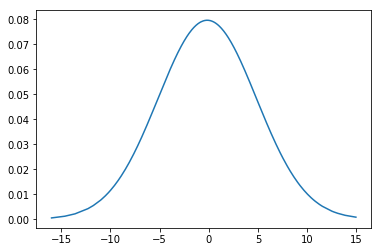

In [13]:
data = np.random.normal(0, 5, 1000)
data.sort()
pdf = stats.norm.pdf(data, np.mean(data), np.std(data))
plt.plot(data, pdf)

This kind of distribution makes physical sense; around an expected value, there is a high chance of a small deviation in the actual state, and a low chance of a larger deviation. If there are more complicated processes causing noise, they can be modelled as their own dynamic systems and incorporated into the state-transition and output equations. For example, if there is skewed noise, an expectation of that noise can augment the state, and any deviations around that can be considered Gaussian.

## Covariance

The multidimensional version of variance is called covariance. Covariance describes how much one variable changes with another. Explicitly, it is given by

$\text{cov}(x, y) = E\left[[x - E[x]] [y - E[y]]\right]$

where $E$ is an expected value operator. It can be verified that the covariance of a variable with itself is just its variance. 

Covariance is useful for Kalman filtering because even if the state variable update rules are different, they are likely to be correlated, and this correlation can usually be understood physically. For example, a higher cart velocity would correlate to a higher predicted next position value, so there is likely a nonzero positive covariance between the cart's velocity and position.

The covariance of a predicted state can be represented in a square matrix $P$, where $P_{ij} = \text{cov}(x_i, x_j)$. The variances of each variable are down the diagonal. Additionally, because covariance is independent of the order of the variables, the matrix $P$ is symmetric.

Covariance changes under a matrix multiplication (like in a state-transition step) according to $x \to Ax, P \to APA^T$.

## Sensor measurements and noise

We can observe the state of a dynamic system based on sensor measurements that may be noisy. Let the matrix C translate between a state at some specific time and what its measurements should be at that time. These can then be compared to the actual measurements at that time, $\vec{y}$.

The measurements have their own covariance that is associated with the sensor being unreliable (take any sensor, such as an accelerometer or pressure sensor, hold it in one place, and watch it fluctuate) so measurements aren't a perfect representation of what a dynamic system is doing. 

## Deriving the Kalman Filter governing equations

### Predict

The Kalman prediction step involves advancing the state through a single timestep based on the previous state and the control input at that time. With this, the covariance matrix also has to be updated and state noise associated with environmental disturbances added to it. Let the state noise matrix be $Q$; then the prediction equations are

$\begin{eqnarray*}
x^-(t + \Delta t) = Ax(t) + Bu(t)\\
P^-(t + \Delta t) = AP(t)A^T + Q
\end{eqnarray*}
$

Mathematically, it is fine for any of these to vary in time, but dynamic systems can usually be modelled fairly accurately with constant $A$ and $B$ matrices and a constant noise model. The state and covariance have a negative superscript because they have not yet been updated, as will be described below; however, for simulations of dynamic systems, it is sufficient to just predict as time advances. 

In [ ]:
# example of Kalman prediction

### Update

The part of the Kalman filter that ends up reducing the system state error is the update step. Here, we want to take our estimate of the error (in some sources, this is optimistically called the innovation),

$e(t) = \vec{y}(t) - C\vec{x^-}(t)$

and multiply this element-wise by the Kalman gain $K$ to get an updated state that is hopefully closer to reality:

$\vec{x} = \vec{x^-} + Ke = \vec{x^-} + K(\vec{y} - C\vec{x^-}) = [I - KC]\vec{x^-} + K\vec{y}$

where $\vec{x^-}$ is the *a priori* state, i.e. the state before the Kalman update, and $\vec{x}$ is the *a posteriori* state, i.e. that after the update. The covariance also updates with this step. The new covariance has components from the noise associated with $\vec{x^-}$ being multiplied by $[I - KC]$ and $\vec{y}$ being multiplied by $K$; the covariance $P^-$ is updated by the first, and the measurement noise $R$ is incorporated into the new covariance by the second.

$P = [I - KC]P^- [I - KC]^T + KRK^T$

We can find the Kalman gain by attempting to minimize the covariance of the *a posteriori* state. We set the following:

$\frac{\partial \text{Tr} P}{\partial K} = 0 \implies \frac{\partial \text{Tr} P^-}{\partial K} - 2 \frac{\partial \text{Tr} KCP^-}{\partial K} + \frac{\partial \text{Tr} KCP^- C^T K^T}{\partial K} + \frac{\partial \text{Tr} KRK^T}{\partial K} = 0$

Applying trace differentiation properties (namely that $\frac{\partial \text{Tr} ABA^T}{\partial A} = 2AB$ for symmetric $B$, and $\frac{\partial \text{Tr} AC}{\partial A} = C^T$), we get

$-2P^-C^T + 2KCP^-C^T + 2KR = 0$

which allows us to find $K$,

$K = P^-C^T [CP^-C^T + R]^{-1}$

Therefore, the Kalman update step is fully defined by first finding $K$ according to this formula, then updating the state based on the above equation. This is the optimal linear state estimate, based on which a controller can operate 

## Implementation

The general dynamic system simulator is in the next cell. It is implemented as a Python abstract class (a class that can't directly be instantiated) that other classes can inherit from. Derived classes have to:

- implement their own state-transition matrices and external input ($A$, $B$, $u$) in the methods `evolve` and `ext_input`.
- define their own state and simulation end condition (`self.state`, `self.simend`) and update `self.simend` in `evolve`.
- define a `reset` method that returns the object state to what it was before simulation. (Ideally you'd do this entirely in the state, but for the rocket example below I found it was easier to have some class attributes other than the state to keep algebra simpler.)
- define 
 - the initial state covariance matrix P
 - the state-transition noise matrix Q
 - the state-to-measurement matrix H 
 - the measurement covariance matrix R. 
 
Assuming these are defined for each instance of a `DynamicSystem` child class, any `DynamicSystem` can run simulations (i.e. just transition states over time without the Kalman update step), or filter its own state based on noisy sensor data. 

In [ ]:
class DynamicSystem(ABC):
    '''
    An abstract dynamic system with time-dependent state evolution, time-independent state to measurement mapping,
    and initial measurement covariances, constructed to facilitate Kalman filtering.

    Required parameters:
        simend (bool)
        state (ndarray)
        P (ndarray)
        Q (ndarray)
        H (ndarray)
        R (ndarray)
        STATE_SIZE (int)
        INPUT_SIZE (int)
    Required methods:
        evolve
        ext_input
        reset
    '''

    @abstractmethod
    def evolve(self, t, dt):
        # Given t and dt, returns the dynamic system's A and B matrices. Also sets simend based on state.
        pass

    @abstractmethod
    def ext_input(self, t):
        # Given t, returns u(t) and a u_status that may be None.
        pass

    @abstractmethod
    def reset(self):
        # restores all internal variables that may have changed during a simulation run.
        pass

    def predict(self, t, dt):
        # predicts system state at time t+dt based on system state at time t
        A, B = self.evolve(t, dt)
        u, u_status = self.ext_input(t)
        state_predicted = A.dot(self.state) + B.dot(u)
        P_predicted = A.dot(self.P.dot(A.T)) + self.Q
        return (u, u_status, state_predicted, P_predicted)

    def sim_results(self, t, k, states, inputs, terminate):
        self.reset()
        print("Simulation ended at t =", t, "s due to", terminate)
        processed_states = np.zeros([self.STATE_SIZE, k])
        processed_inputs = np.zeros([self.INPUT_SIZE, k])
        states = states.T
        inputs = inputs.T
        for i, state in enumerate(states):
            processed_states[i] = state[:k]
        for i, input in enumerate(inputs):
            processed_inputs[i] = input[:k]
        return (np.linspace(0,t,k+1)[:k], processed_states, processed_inputs)

    def simulate(self, dt=0.01, timeout=30, verbose=False, kalman=None):
        interrupt = False
        t, k = 0, 0
        if kalman is not None:
            m = 0
            measure_times = kalman[0]
        states = np.zeros([int(np.ceil(timeout/dt))+1, self.STATE_SIZE])
        inputs = np.zeros([int(np.ceil(timeout/dt))+1, self.INPUT_SIZE])
        terminate = "error."
        try:
            while t < timeout:
                if verbose and hasattr(self, "compact_status") and k % 100 == 0:
                    self.compact_status(t)
                states[k] = self.state
                inputs[k], input_status, state_predicted, P_predicted = self.predict(t, dt)
                if kalman is not None and m < measure_times.size and np.isclose(t, measure_times[m], atol=dt/2):
                    self.state, self.P = self.update(state_predicted, P_predicted, kalman[1][m])
                    m += 1
                else:
                    self.state = state_predicted
                    self.P = P_predicted
                if verbose and input_status is not None and k % 100 == 0:
                    print(input_status)
                if self.simend:
                    terminate = "end condition."
                    break
                t += dt
                t = np.round(t, -int(np.log10(dt)))
                k += 1
        except KeyboardInterrupt:
            print("\nSteps completed:", k)
            terminate = "interrupt."
        if t >= timeout:
            terminate = "timeout."
        return self.sim_results(t, k, states, inputs, terminate)

    def measure(self, state):
        return self.H.dot(state)

    def update(self, state_predicted, P_predicted, measurement):
        error = measurement - self.measure(state_predicted)
        K = P_predicted.dot(self.H.T.dot(np.linalg.inv(self.H.dot(P_predicted.dot(self.H.T)) + self.R)))
        state_updated = state_predicted + K.dot(error)
        P_updated = P_predicted - K.dot(self.H.dot(P_predicted))
        return (state_updated, P_updated)

## The rocket dynamic model

We'll demonstrate Kalman filtering on data collected from a rocket launch. The rocket is called Sub-Arktos. It was made by the UC Berkeley high-powered rocketry team, CalSTAR, as a subscale launch vehicle for the NASA Student Launch competition in 2017.

High-powered rockets usually fly using commercial off-the-shelf motors, which provide on the order of 10 Gs in thrust over a very short time. Once a rocket reaches apogee (the highest point of flight), it deploys parachutes so that it comes down gradually rather than at its terminal velocity, so that it can be recovered without damage. The condition for parachute deployment is usually reaching apogee, a specific time delay after apogee, or reaching a specific altitude during descent. Sub-Arktos flew with two parachutes, which is reasonably standard for an apogee on the order of a mile. The first was a small "drogue" chute deployed at apogee, so as to make the rocket fall gradually, but still fast enough that it does not drift too much during descent. The second was a larger "main" chute deployed at an altitude of 800 feet, to ensure the rocket is falling slowly enough that impact is soft and there is no damage to the airframe.

To deploy parachutes at the correct time, it is necessary to have a good idea of the rocket's state at any given time. However, knowing the rocket's state is dependent on altimeter and accelerometer data, which may be noisy. But since we know from simulation approximately what the rocket state at any given time should be, determining when the rocket is likely to be at apogee or at some specific altitude during descent is a perfect Kalman filtering problem.

If you're interested in how the rocket simulation was developed, I'd love to discuss it in detail in person or in a different notebook; for here I'll just use it to demonstrate filtering without explaining much of what's under the hood. Essentially, it's just solving for the rocket's position, velocity, and acceleration based on those values at the previous timestep and the force on the rocket over time. Accurately modelling the force was the difficult part; after that, it's essentially just like the example above.

The state-transition equations can be discretized according to the formulas given previously to get

$\begin{bmatrix} x(t + dt) \\ \dot{x}(t + dt) \\ \ddot{x}(t + dt) \end{bmatrix} = \begin{bmatrix} 1 & dt & \frac{dt^2}{2} \\ 0 & 1 & \frac{dt}{2} \\ 0 & 0 & 0 \end{bmatrix} \begin{bmatrix} x(t) \\ \dot{x}(t) \\ \ddot{x}(t) \end{bmatrix} + \begin{bmatrix}0 \\ \frac{dt}{2m(t)} \\ \frac{1}{m(t)} \end{bmatrix} f(t)$

Ordinarily, the 2D state $\begin{bmatrix} x(t) & \dot{x}(t) \end{bmatrix}^T$ would suffice, but I included acceleration in the state because one of the sensors is an accelerometer, and for Kalman filtering to work, the measurements have to depend only on the state.

It should also be noted that this is an approximation, using second-order (velocity verlet) integration instead of something like a fourth-order Runge-Kutta method. You could do that in the form $x(t + dt) = Ax(t) + Bu(t)$ as well, but $A$ and $B$ would vary with time (more accurately, they would vary with the state) which makes it computationally difficult to filter in real time.

Note that there's a slight oversimplification that both my simulation and the reference simulation make, to do with main parachute deployment. Both model it as an instantaneous process, with the chute providing zero drag until it's time for it to be deployed and its full drag thereafter. This essentially creates a Dirac delta-type spike in the acceleration that's slightly offset between the reference and reality, and likely isn't what you'd see on a real-life accelerometer. Therefore, for this example, we're going to assume that Sub-Arktos only has a drogue chute and no main  chute. This reflects what actually happened to the rocket at its last launch, so it seems reasonable to simulate. If you want to see a simulation with the main parachute included, take a look at 'subarktos/subarktos.py' under this repo.

In [3]:
# Feel free to skip way past this, till I figure out how to hide a code cell in Jupyter.

class Parachute:

    CHUTE_OPEN_DELAY = 0.2
    '''
    diameter : scalar
        Diameter of the parachute.
    cd : scalar
        Drag coefficient of the parachute.
    alt : scalar
        Deployment altitude of the parachute in feet converted to meters.
        If None, considered to be at apogee.
    deployed : bool
        Indicates whether or not the chute has deployed.
    name : string
        Name of the parachute, for reading status.
    t_deployed : scalar
        Time when the parachute was deployed.
    '''
    def __init__(self, diameter, cd, name, alt=None):
        self.b_drag = 1.275 * np.pi * cd * diameter**2/8
        if alt is not None:
            self.alt = alt * 0.3048
        else:
            self.alt = float('inf')
        self.deployed = False
        self.name = name
        self.t_deployed = None

    def drag(self, velocity, t):
        # velocity in m/s
        if not self.deployed or t - self.t_deployed < self.CHUTE_OPEN_DELAY:
            return 0
        return self.b_drag * velocity**2

    def deploy(self, t):
        if not self.deployed:
            print("Deploying", self.name, "at t =", str(t).strip(),"s")
            self.deployed = True
            self.t_deployed = t

class Motor:
    # credit for thrust and mass functions: Aled Cuda
    '''
    mass_init : scalar
        Initial mass of the motor.
    mass_final : scalar
        Final mass of the motor.
    time_burnout : scalar
        Time at which motor burns out in seconds.
    thrust_curve : string
        Name of text file containing thrust curve data.
    time_delay : scalar
        Time between launch and ignition of this motor in seconds.
    '''
    def __init__(self, mass_init, mass_final, thrust_curve, time_delay=0):
        self.mass_init = mass_init
        self.mass_final = mass_final
        self.thrust_data = np.loadtxt(thrust_curve)
        # adding thrust(t = 0) = 0 to help interpolation
        self.thrust_data = np.concatenate((np.array([[0,self.thrust_data[::,1][1]/2]]), self.thrust_data), axis=0)
        self.max_thrust = np.amax(self.thrust_data,0)[1]
        assert time_delay >= 0, "Cannot have a negative delay."
        self.time_delay = time_delay
        # adjust for time delay in thrust data
        self.thrust_data = self.thrust_data + np.vstack([np.array([time_delay,0])]*self.thrust_data.shape[0])
        self.time_burnout = np.max(self.thrust_data[::,0]) + time_delay

    def thrust(self, t):
        # If we ask for a time before or after the range we assume thrust is zero
        if t > self.time_burnout or t < self.time_delay:
            return 0
        # Otherwise we use the interpolate function
        return interp.interp1d(self.thrust_data[::,0], self.thrust_data[::,1])(t)

    def mass(self, t):
        if t < self.time_delay:
            return self.mass_init
        elif t > self.time_burnout:
            return self.mass_final
        return ((self.mass_final - self.mass_init)/(self.time_burnout - self.time_delay))*t + self.mass_init

class Sensor:
    '''
    Object that reads in a rocket state variable.
    select : int
        Indicates which state variable is being read: 0 for altitude, 1 for velocity (not expected to be used),
        2 for acceleration.
    var : scalar
        Variance of the sensor.
    data : ndarray
        Collection of n row vectors with two elements: time and sensor reading.
    convert : scalar
        Multiplicative factor from the state variable to the sensor reading. Mostly m to ft conversion.
    '''

    def __init__(self, select, var, data, convert=3.28):
        self.select = select
        self.var = var
        self.data = data
        self.convert = convert

class Rocket(DynamicSystem):

    '''
    A rocket with an altimeter and accelerometer.

    dry_mass : scalar
        Takes in time, returns rocket mass.
    parachutes : list
        A list of Parachute objects.
    motors : list
        A list of Motor objects.
    sensors : list
        A list of Sensor objects. Setting this to the empty list will set Kalman filtering to simulation without updates.
    b_drag : scalar
        Coefficient on v^2 in drag equation. (Not the same as cd.)
        Currently being determined via curve fitting on OpenRocket sim data.
    state : ndarray
        1x3 row vector containing position, velocity, and acceleration in the best units.
        State represented as a row vector, to be transposed if it's important for matrix operations.
    apogee : bool
        Boolean to indicate if apogee has been reached yet, to update parachute states.
    '''
    STATE_SIZE = 3
    INPUT_SIZE = 1

    def __init__(self, dry_mass, parachutes, motors, sensors, b_drag):
        self.dry_mass = dry_mass
        self.parachutes = parachutes
        self.motors = motors
        self.sensors = sensors
        self.b_drag = b_drag
        self.H = np.zeros((len(sensors), 3))
        self.R = np.zeros((len(sensors), len(sensors)))
        for i,s in enumerate(sensors):
            self.H[i][s.select] = s.convert
            self.R[i][i] = s.var
        self.P = np.zeros([self.STATE_SIZE, self.STATE_SIZE])
        q = 2
        d = 0.001 # sampling time difference of one of the sensors. Just in here for the noise model, to be updated.
        # constant acceleration approximation: change this later
        self.Q = q * np.array([[d**4/4, d**3/3, d**2/2], [d**3/3, d**2/2, d], [d**2/2, d, 1]])
        # for now these are hardcoded in, but find a way to remove them and still detect apogee:
        self.stdev_alt = np.sqrt(5.54)
        self.stdev_acc = np.sqrt(62.953)
        self.apogee = False
        self.simend = False
        self.max_thrust = sum([m.max_thrust for m in self.motors])
        self.state = np.array([0, 0, 0])
        self.state[2] = self.get_thrust(0)/self.get_mass(0)
        print(self.state)

    def get_mass(self, t):
        return self.dry_mass + sum([m.mass(t) for m in self.motors])

    def get_thrust(self, t):
        # to do: burnout detection.
        return sum([m.thrust(t) for m in self.motors])

    def get_rocket_drag(self):
        magnitude = self.b_drag * self.state[1]**2
        if not self.apogee:
            return -magnitude
        else:
            return magnitude

    def get_chute_drag(self, t):
        return sum([p.drag(self.state[1], t) for p in self.parachutes])

    def ext_input(self, t, mass=None):
        if mass is None:
            mass = self.get_mass(t)
        thrust = self.get_thrust(t)
        if thrust == 0 and t < 0.2:
            # to do: better way of detecting 'still on the pad'
            gravity = 0
        else:
            gravity = -9.8 * mass
        rocket_drag = self.get_rocket_drag()
        if thrust > 0.05*self.max_thrust:
            assert thrust > np.abs(rocket_drag), "Excessive drag"
        chute_drag = self.get_chute_drag(t)
        return (thrust + gravity + rocket_drag + chute_drag, str([thrust, gravity, rocket_drag, chute_drag]) + '\n')

    def evolve(self, t, dt, order=2):
        # order: of integration.
        m = self.get_mass(t)
        if order == 1:
            A = np.array([[1, dt, dt**2/2],[0, 1, dt],[0, 0, 0]])
            B = np.array([0, 0, 1/m])
        elif order == 2:
            A = np.array([[1, dt, dt**2/2], [0, 1, dt/2], [0, 0, 0]])
            B = np.array([0, dt/(2*m), 1/m])
        # Orders > 2 to be implemented based on https://math.stackexchange.com/questions/2946737/solving-a-matrix-differential-equation-using-runge-kutta-methods, plus some slightly jank workarounds that allow the 'a' row to still be all zero.
        # Check for apogee
        if not self.apogee:
            try:
                assert self.state[0] > -self.stdev_alt, "you will not go to space today"
            except AssertionError as e:
                e.args += ("Time", t, "State", self.state)
                raise
            if self.state[1] < -self.stdev_acc and self.state[2] < -self.stdev_acc:
                # this is kind of a jank apogee check, especially because I'm comparing velocity to a deviation in acceleration
                try:
                    assert self.get_thrust(t) == 0, "If you're at apogee, the motor can't still be burning"
                except AssertionError as e:
                    e.args += ("Time", t, "thrust", self.get_thrust(t), "state:", self.state)
                    raise
                self.apogee = True
                print("Hit apogee at altitude",str(np.round(3.28*self.state[0], 2)),"ft")
                for p in self.parachutes:
                    if p.alt is None:
                        p.deploy(t)
        # Check for altitude-based chute deployment
        # To do: nicer way of doing this than checking at every timestep.
        if self.apogee and not all([p.deployed for p in self.parachutes]):
            for p in self.parachutes:
                if p.alt > self.state[0]:
                    p.deploy(t)

        # Check for ground hit
        if self.apogee and self.state[0] < self.stdev_alt and A.dot(self.state)[0] < -2*self.stdev_alt:
            self.simend = True
        return (A, B)

    def reset(self):
        # for some reason copy.deepcopy isn't working so here
        for p in self.parachutes:
            p.deployed = False
            p.t_deployed = None
        self.apogee = False
        self.state = np.array([0,0,0])
        self.simend = False

    def status(self):
        print("Altitude:", self.state[0])
        print("Velocity:", self.state[1])
        print("Acceleration:", self.state[2])
        print("Apogee hit:", self.apogee)
        for p in self.parachutes:
            print(p.name, "deployed:", p.deployed)
        print("Ground hit:", self.simend)

    def compact_status(self, t):
        print(t, self.state, self.apogee, [p.deployed for p in self.parachutes], self.simend)

NameError: name 'DynamicSystem' is not defined

In [ ]:
'''subarktos_sim_no_main.csv has data from the reference simulator. We're going to consider this to be our sensor data, 
because then we know exactly what the noise is. We initialize sensor data before the rocket because the rocket 
needs information on how noisy its sensors are.'''

%matplotlib inline
sim = pd.read_csv("subarktos/subarktos_sim_no_main.csv", comment='#')
read_t = np.array(sim['Time (s)'])
read_alt = np.array(sim['Altitude (ft)'])
read_vel = np.array(sim['Vertical velocity (ft/s)']) # not a sensor
read_acc = np.array(sim['Vertical acceleration (ft/s^2)'])
t_apogee = 16.208 # I read this off the csv, ideally I'd parse the comments
read_drag = np.array(sim['Drag force (N)'])
read_thrust = np.array(sim['Thrust (N)'])
read_mass = np.array(sim['Mass (oz)']) 
read_gravity = np.array(sim['Gravitational acceleration (ft/s^2)']) * read_mass * 0.008641

def force(t):
    n = np.where(read_t == t)[0][0]
    if t < t_apogee:
        return read_thrust[n] - read_drag[n] - read_gravity[n]
    else:
        return read_drag[n] - read_gravity[n]
    
read_force = (np.vectorize(force))(read_t)

# To demonstrate filtering, we apply Gaussian noise, which we're going to try and remove.

sigma_alt = np.max(read_alt)/64
sigma_acc = np.max(read_acc)/64
alt_noise = np.random.normal(0, np.sqrt(sigma_alt), np.size(read_alt))
acc_noise = np.random.normal(0, np.sqrt(sigma_acc), np.size(read_acc))

In [ ]:
# to get the drag coefficient for subarktos, we curve-fit drag to velocity squared over the ascent.
n_ascent = np.where(np.isclose(read_t, t_apogee, atol=1e-2))[0][0]
v2 = read_vel**2
plt.plot(v2[np.arange(0,n_ascent,1)], read_drag[np.arange(0,n_ascent,1)], label="Data")
slope, intercept, _, _, _ = stats.linregress(v2[np.arange(0,n_ascent,1)],read_drag[np.arange(0,n_ascent,1)])
plt.plot(read_vel**2, slope*(read_vel**2) + intercept, label="Curve fit")
plt.legend(loc='lower right')

In [ ]:
'''Initializing Sub-Arktos. A couple of things are done weirdly because I'm pulling from simulation data, some of which
is being considered simulation data and some of which will be used as sensor data. Usually the motor's final mass 
would be nonzero and would be measured beforehand without the motor in it, here I've just shifted mass around a bit.
Also, sigma_alt and sigma_acc are manufactured numbers; to test those you could just have both sensors read while at 
rest and find their variances. Finally, the weirdest part is drag is determined by curve-fitting (and it's pulling
the _wrong way_ for some reason).
'''

mass = read_mass[-1] * 0.0283495 #kg
motor = Motor(1.223 - 0.713, 0, "subarktos/J450.txt") # motor starts with a mass 1.223 kg and ends with 0.713 kg.
# These are standard numbers you can look up for any COTS motor.
drogue = Parachute(0.3, 1.8, "Drogue")  # drogue parachute diameter in m, and Cd.
#main = Parachute(0.9, 2.2, "Main", alt=800)
altimeter = Sensor(0, sigma_alt, None) # sensor is reading state variable 0 (altitude) and has the given variance
accelerometer = Sensor(2, sigma_acc, None) # reading state variable 2 (acceleration)
drag = slope # determined via curve fitting to drag = -bv*2
subarktos = Rocket(mass, [drogue], [motor], [altimeter, accelerometer], drag)

def test_acc_differences(subarktos, read_t, read_acc):
    def new_ext_input(t):
        if t < np.min(read_t) or t > np.max(read_t):
            return (0, "OpenRocket sim data")
        return (interp.interp1d(read_t, read_acc)(t)/3.28 * subarktos.get_mass(t), "OpenRocket sim data")

    subarktos.ext_input = new_ext_input
    return subarktos

#subarktos = test_acc_differences(subarktos, read_t, read_acc)


In [ ]:
test_time = np.linspace(0,0.01,100)
plt.plot(test_time, np.vectorize(lambda x: [print(subarktos.ext_input(x)[1]), subarktos.ext_input(x)[0]][1])(test_time))

In [ ]:
test_time = np.linspace(0,0.01,100)
plt.plot(test_time, np.vectorize(interp.interp1d(read_t, read_force))(test_time))

In [ ]:
model_mass = np.vectorize(subarktos.get_mass)(read_t)
plt.plot(read_t, (np.array(sim['Mass (oz)']) * 0.0283495 - model_mass))

In [ ]:
plt.plot(read_t, read_thrust - np.vectorize(subarktos.get_thrust)(read_t))

In [ ]:
#plt.plot(np.linspace(0,120,10000), np.vectorize(lambda x: subarktos.ext_input(x)[0])(np.linspace(0,120,10000)))

In [ ]:
# Simulating the system
subarktos.reset()
times, states, inputs = subarktos.simulate(dt=0.001, timeout=120, verbose=False)

In [ ]:
# let's see how that compares to the reference simulation.

plt.figure()
plt.plot(times, 3.28*states[0], label='subarktos.simulate()')
plt.plot(read_t, read_alt, label='OpenRocket simulation')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Altitude (ft)")

In [ ]:
plt.figure()
plt.plot(times, 3.28*states[1], label='subarktos.simulate()')
plt.plot(read_t, read_vel, label='OpenRocket simulation')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (ft/s)")

In [ ]:
plt.figure()
plt.plot(times, 3.28*states[2], label='subarktos.simulate()')
plt.plot(read_t, read_acc, label='OpenRocket simulation')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (ft/s^2)")

In [ ]:
'''Now let's filter! We can do that by telling the simulation to update using noisy sensor data instead of no data. 
Later this'll pull from subarktos.sensors, but for now they're passed in as a parameter to 'simulate'.'''

sensor_data = np.vstack([(read_alt + alt_noise, read_acc + acc_noise)]).T
filtered_times, filtered_states, _ = subarktos.simulate(dt=0.001, timeout=120, kalman=(read_t, sensor_data))

In [ ]:
# To see what that did, let's plot the altimeter readings (without noise) over the filtered results
plt.plot(read_t, read_alt, label="OpenRocket without noise")
plt.plot(filtered_times, 3.28*filtered_states[0], label="subarktos.simulate() filtered from OpenRocket + noise")
plt.legend(loc='upper right')
plt.title("Kalman filtered rocket altitude against true values.")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (ft)")

In [ ]:
# and the accelerometer readings
plt.plot(read_t, read_acc, label="OpenRocket without noise")
plt.plot(filtered_times, 3.28*filtered_states[2], label="subarktos.simulate() filtered from OpenRocket + noise")
plt.legend(loc='upper right')
plt.title("Kalman filtered rocket acceleration against true values.")
plt.xlabel("Time (s)")
plt.ylabel(r"Acceleration $(ft/s^2)$")

In [ ]:
# To really see the effect of filtering, let's plot the errors in both before and after filtering.

def interpolate_state_data(data):
        def toreturn(t):
            if t < np.min(read_t) or t > np.max(read_t):
                return 0
            return interp.interp1d(read_t, data)(t)
        return toreturn
    
alt_error_after = 3.28*filtered_states[0] - np.vectorize(interpolate_state_data(read_alt))(filtered_times)
acc_error_after = 3.28*filtered_states[2] - np.vectorize(interpolate_state_data(read_acc))(filtered_times)

In [ ]:
# altitude error
plt.plot(read_t, alt_noise, label="Error before filtering")
plt.plot(filtered_times, alt_error_after, label="Error after filtering")
plt.title("Altitude error reduction due to Kalman filtering.")
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Error in altitude (ft)")

print(np.std(alt_noise))
print(np.std(alt_error_after))

In [ ]:
# acceleration error
'''n = np.where(np.isclose(read_t, t_apogee, atol=1e-2))[0][0]
m = np.where(np.isclose(filtered_times, t_apogee, atol=1e-2))[0][0]
ns = np.where(np.isclose(read_t, 0.2,atol=1e-2))[0][0]
ms = np.where(np.isclose(filtered_times,0.2,atol=1e-2))[0][0]'''
plt.plot(read_t, acc_noise, label="Error before filtering")
plt.plot(filtered_times, acc_error_after, label="Error after filtering")
plt.title("Acceleration error reduction due to Kalman filtering.")
plt.legend(loc='lower right')
plt.xlabel("Time (s)")
plt.ylabel(r"Error in acceleration $(ft/s^2)$")

print(np.std(acc_noise))
print(np.std(acc_error_after))